# Project : Spotify data analysis and classification
**Groupe projet :** Loïc Legroux et Julian Hutin

In this project we will use data obtained from the Spotify API to analyse, visualise and make predictions using models trained on the data.

## Importing libraries and the Spotify dataset
---



In [1]:
# Imports used throughout the project
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn import model_selection, tree, svm
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import f1_score, r2_score, confusion_matrix,mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings('ignore')

## Exercice 1 : Music genre classification
---

In this exercise the aim is to train a model that can predict the genre of a piece of music from some given data.

For this exercise, two datasets are provided:

- `spotify_dataset_train.csv` containing 25,492 pieces of music from one of 23 possible genres

- `spotify_dataset_test.csv` containing 2833 pieces of music for which the genre is not provided and on which our model will make predictions

For ease of use, it is decided to replace the full release date with the release year only.


In [2]:
# We import the training and test datasets
train = pd.read_csv("/kaggle/input/spotify/spotify_dataset_train.csv")
test = pd.read_csv("/kaggle/input/spotify/spotify_dataset_test.csv")

# Only the year of the release date is kept
for i in range(len(train)):
  train['release_date'].loc[i] = int(train['release_date'].loc[i][0:4])
for i in range(len(test)):
  test['release_date'].loc[i] = int(test['release_date'].loc[i][0:4])

train.head()

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,2015,False,38,0.509,0.8720,2,-5.170,1,0.0547,0.0396,0.000015,0.3310,0.4860,95.969,194375,4,country
1,2021,False,58,0.182,0.0377,11,-33.748,0,0.0391,0.9870,0.957000,0.0804,0.0923,100.482,241804,4,classical
2,2013,False,36,0.550,0.9410,0,-3.128,0,0.0849,0.0182,0.003750,0.3120,0.3510,145.006,260276,4,rap
3,2012,False,0,0.569,0.7190,6,-8.399,0,0.0663,0.8670,0.941000,0.1760,0.6430,145.118,165200,4,blues
4,2008,False,0,0.631,0.6610,8,-5.694,1,0.0558,0.0146,0.720000,0.3650,0.3300,130.004,245933,4,dance


### A. Analysis

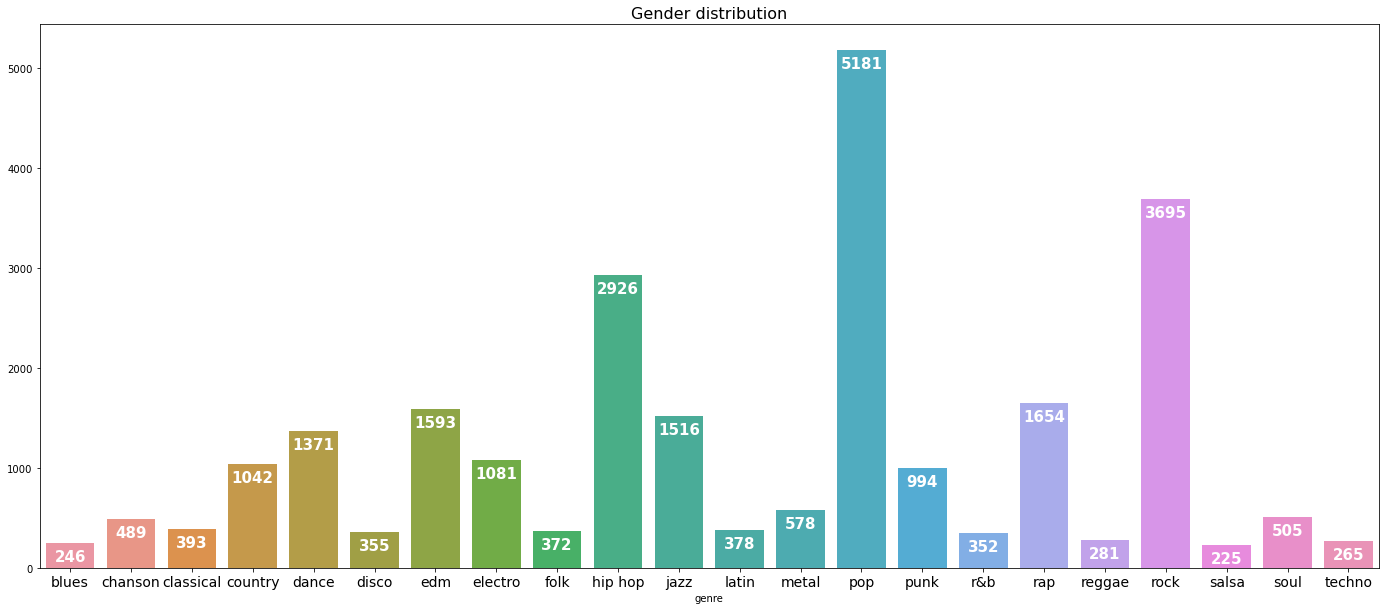

In [3]:
# We are interested in the gender distribution in the dataset
genre_counts = train.groupby('genre')['mode'].count()

plt.figure(figsize=(24,10))
plt.title('Gender distribution', size=16)
plt.xticks(size=14)

graphe = sns.barplot(genre_counts.index, genre_counts.values);

for index, row in enumerate(genre_counts):
     graphe.text(index, row-180, row, color='white', ha="center", size='15', weight='bold')

plt.show()

Not too surprisingly, pop music is the most common.

The distribution of music styles is quite uneven, with the trio: **pop / hip hop / rock** accounting for a major part of the data.

This may be problematic for the performance of the model compared to a dataset where all genres would be equally distributed.

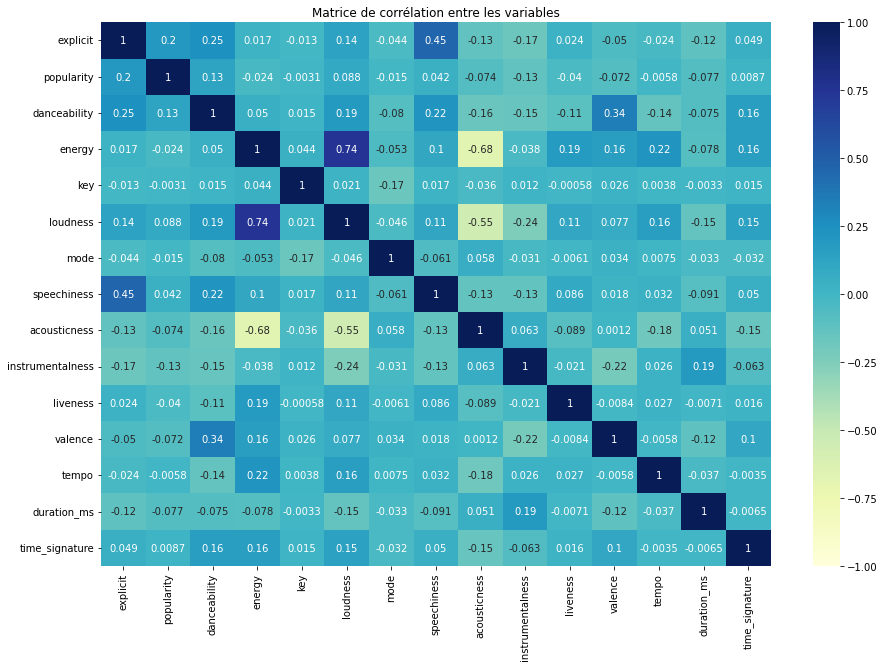

In [4]:
#We look at whether the variables are correlated with each other
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(train.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)

plt.title('Matrice de corrélation entre les variables')
plt.show()

It can be seen from the correlation matrix above that our variables are fairly uncorrelated with each other, except for a few:

- `loudness` and `energy` are strongly positively correlated, which is consistent: cheerful music is generally loud

- `speechiness` and `explicitness` which makes sense because it is not possible for an explicit song to have no lyrics

- `danceability` and `valence` - valence represents the 'happy' aspect of a piece of music, it is normal that these two variables are related because people usually dance to happy music


There are also two negative correlations:

- `Acousticness` and `energy`: purely acoustic music is generally quiet compared to music using synthetic instruments

- `Acousticness` and `loudness`: similarly, basic instruments do not produce excessively loud music

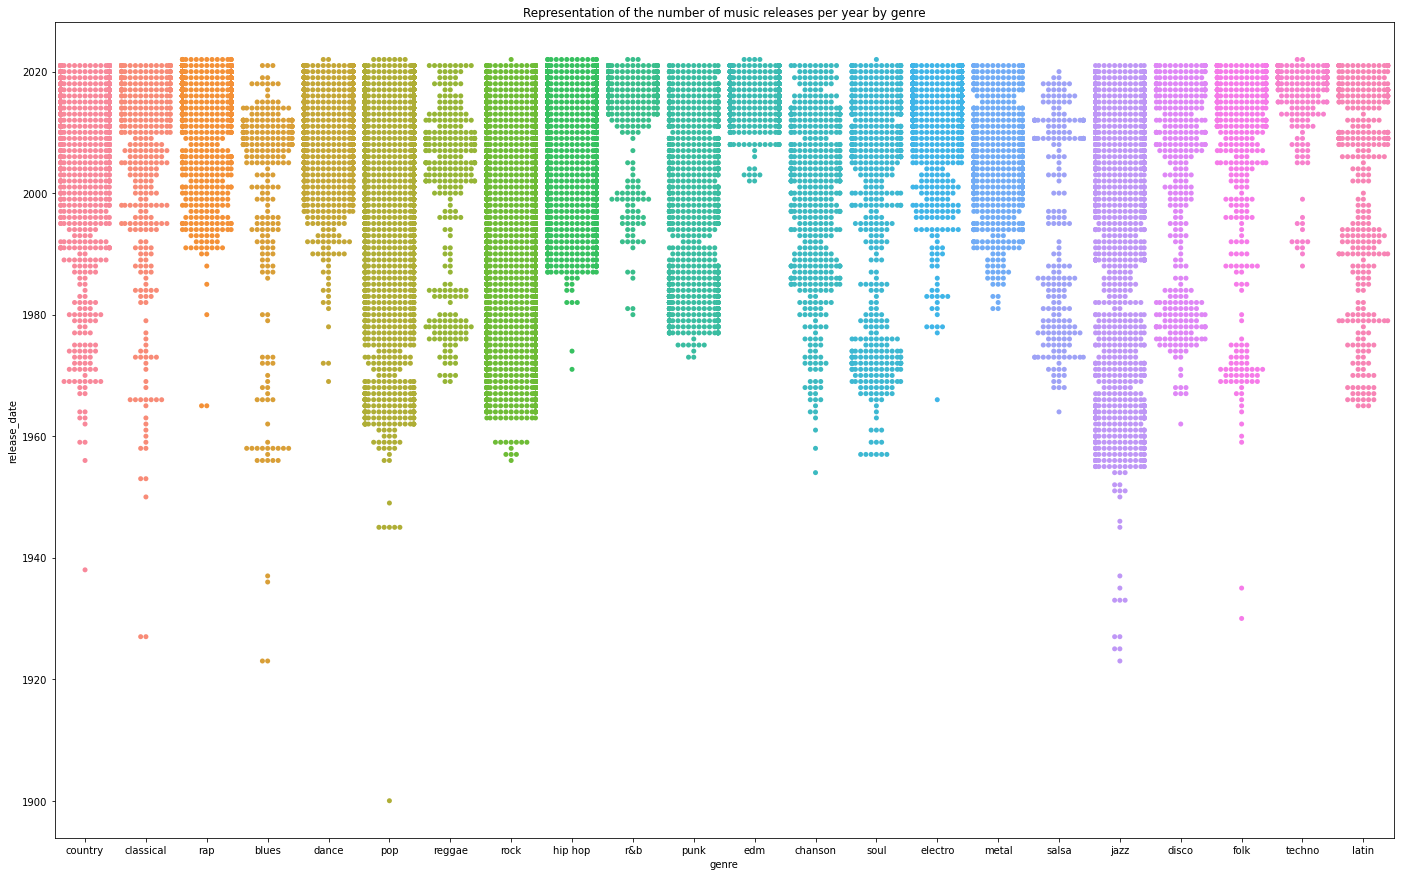

In [5]:
# We plot a swarm plot to see the distribution of music by year and genre
plt.figure(figsize=(24,15))

sns.swarmplot(x=train['genre'], y=train['release_date'])

plt.title("Representation of the number of music releases per year by genre")
plt.show()

Thanks to the graph above, we have an idea of how many songs are released each year according to their genre.

Each point represents a certain number of songs, so the more points aligned horizontally, the more songs were released in that year.

Although most of the music is quite recent, it is still possible to notice some trends:

- most rap music is recent, which is verified in this graph

- jazz is the genre with the most old music, which is also consistent because it is one of the oldest genres presented here

On the other hand, it is surprising to see that most classical music has been released recently, while most of it was written a long time ago.

A potential explanation is that the period performances were obviously not recorded and the release date corresponds to the date of the musician who played the scores.

<Figure size 1728x1080 with 0 Axes>

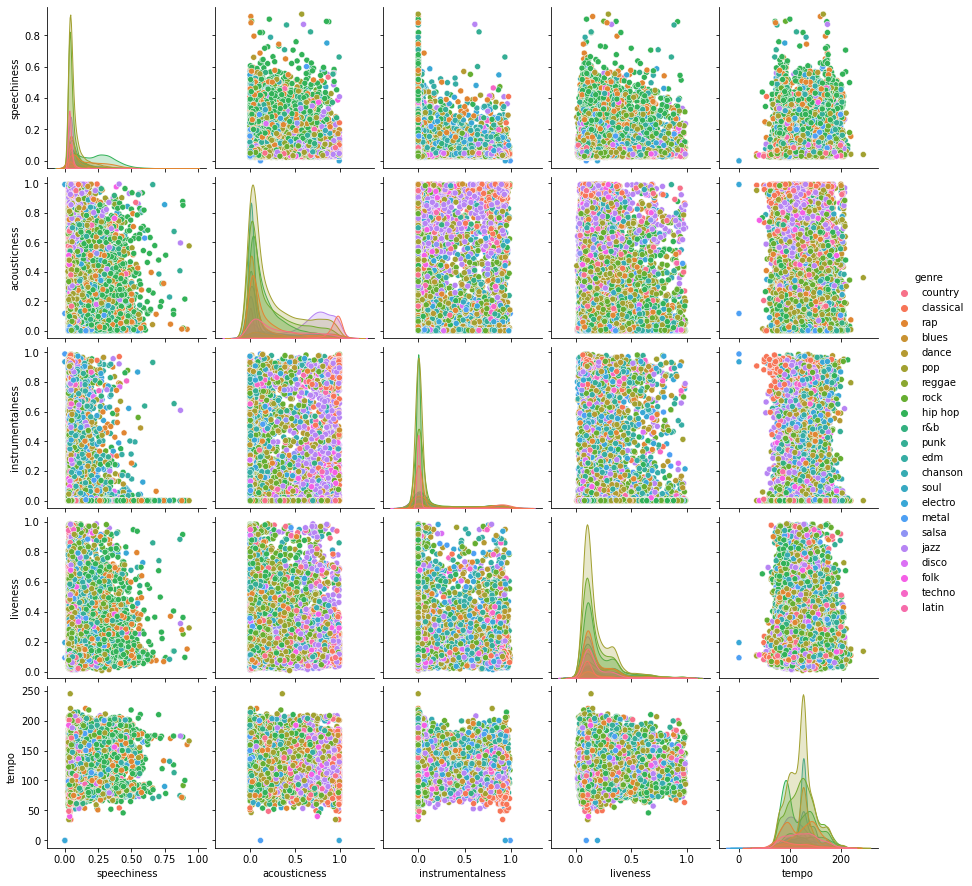

In [6]:
# Remove characteristics that are not purely musical
drops = ['release_date', 'explicit', 'key', 'loudness', 'mode', 'valence', 'duration_ms', 'time_signature', 'popularity', 'danceability', 'energy']

spotify_data = train.drop(drops, axis=1)

# We plot the distribution of the variables
plt.figure(figsize=(24,15))

sns.pairplot(spotify_data, hue='genre')

plt.show()

This graph shows us the distribution of the values taken by the variables of musical type. In spite of the large number of genres, which reduces the readability, we can notice some details:

- a large majority of dance sounds have the same tempo, contrary to other musical styles where the values are more spread out

- in terms of acoustics, jazz and classical music are isolated from the other genres with a distribution centred on much higher values

- in general, the distributions of the genres are centred at the same point but differ in their standard deviations

### B. Data preparation and standardisation

In [7]:
# We clean the data to keep only the important data for classification: 
# Features that do not provide information on the style of music are removed

train_label = train['genre']
train_data = train.drop(['genre'], axis=1)
test_data = test

train_data[:10]

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2015,False,38,0.509,0.8720,2,-5.170,1,0.0547,0.03960,0.000015,0.3310,0.4860,95.969,194375,4
1,2021,False,58,0.182,0.0377,11,-33.748,0,0.0391,0.98700,0.957000,0.0804,0.0923,100.482,241804,4
2,2013,False,36,0.550,0.9410,0,-3.128,0,0.0849,0.01820,0.003750,0.3120,0.3510,145.006,260276,4
3,2012,False,0,0.569,0.7190,6,-8.399,0,0.0663,0.86700,0.941000,0.1760,0.6430,145.118,165200,4
4,2008,False,0,0.631,0.6610,8,-5.694,1,0.0558,0.01460,0.720000,0.3650,0.3300,130.004,245933,4
5,2016,True,50,0.698,0.8500,10,-5.173,0,0.0285,0.00194,0.005920,0.1180,0.1940,120.029,230000,4
6,1977,False,0,0.832,0.5810,7,-15.031,1,0.0482,0.04410,0.000376,0.4990,0.9680,132.932,449880,4
7,2013,True,0,0.523,0.4380,0,-11.490,0,0.0356,0.86700,0.072300,0.1230,0.1060,126.028,245240,4
8,2018,True,64,0.652,0.8180,11,-4.223,1,0.2210,0.12900,0.000000,0.2340,0.3730,92.246,204959,4
9,1973,False,0,0.504,0.7390,9,-7.265,1,0.0316,0.01790,0.080000,0.0949,0.4170,128.918,248360,4


In [8]:
# The list of genres is extracted
def get_genres(labels):
    genres = []
    for i in range(len(labels)):
        if labels.values[i] not in genres:
            genres.append(labels.values[i])
    return genres

genres = get_genres(train_label)
genres

['country',
 'classical',
 'rap',
 'blues',
 'dance',
 'pop',
 'reggae',
 'rock',
 'hip hop',
 'r&b',
 'punk',
 'edm',
 'chanson',
 'soul',
 'electro',
 'metal',
 'salsa',
 'jazz',
 'disco',
 'folk',
 'techno',
 'latin']

In [9]:
# We get the name of the features of the dataset
features = train_data.columns

We will now normalise our data, especially those that are not scaled from 0 to 1, so that we can use them as input to our models.

In [10]:
# Training data is normalized from 0 to 1
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test)

train_data

array([[0.94262295, 0.        , 0.3877551 , ..., 0.39232993, 0.07227146,
        0.8       ],
       [0.99180328, 0.        , 0.59183673, ..., 0.41077948, 0.09121618,
        0.8       ],
       [0.92622951, 0.        , 0.36734694, ..., 0.5927976 , 0.09859451,
        0.8       ],
       ...,
       [0.95901639, 0.        , 0.7244898 , ..., 0.40873543, 0.10010837,
        0.8       ],
       [0.63934426, 0.        , 0.2755102 , ..., 0.65139629, 0.03558671,
        0.8       ],
       [0.57377049, 0.        , 0.        , ..., 0.5007052 , 0.08538286,
        0.8       ]])

In [11]:
# In order to manipulate the classifiers, we transform the labels into numerical values
true_label = LabelEncoder()

true_label.fit(genres)

true_lab = true_label.transform(train_label)
true_lab

array([ 3,  2, 16, ..., 13, 18, 18])

In [12]:
# We split our data into a training set and a test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, true_lab)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19119, 16), (6373, 16), (19119,), (6373,))

In the following section we will test different models discussed during the SDATA module in order to compare the results.

As the subject indicates, the comparison metric used will be the `F1-score` whose expression is the following:

<br>

\begin{equation*}
\mathbf{F}_1 = 
\frac{2\ TP}{2\ TP + FP + FN} 
\end{equation*}

### C. Models tested

#### 1. Linear Discriminant Analysis

In [13]:
clf1 = LinearDiscriminantAnalysis(solver='eigen', n_components=2)

clf1.fit(X_train,y_train)
y_pred = clf1.predict(X_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.3918091950415817


#### 2. Decision tree

In [14]:
clf2 = tree.DecisionTreeClassifier(random_state=0, criterion="gini", splitter="best", max_depth=7)

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.39588890632355256


#### 3. Support Vector Classification

In [15]:
clf3 = svm.SVC(kernel='poly')

clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.4310371881374549


#### 4. Multi Layer Perceptron

In [16]:
clf4 = MLPClassifier(max_iter=1000)

clf4.fit(X_train, y_train)
y_pred = clf4.predict(X_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.4461007374862702


#### 5. Logistic Regression

In [17]:
clf5 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

clf5.fit(X_train, y_train)
y_pred = clf5.predict(X_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.40859877608661543


#### 6. Random Forest

In [18]:
clf6 = RandomForestClassifier(n_estimators=2000)

clf6.fit(X_train, y_train)
y_pred = clf6.predict(X_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.47434489251529893


In view of the F1-score, we will retain the random forest model because it appears to be the most suitable for solving our problem.

In order to see how it works in more detail, we will display its confusion matrix as well as the components that have the most influence on this model.

In [19]:
#Show some predictions
for i in range(10):
  print(f"True = {y_test[i]}, Predict = {y_pred[i]}")

True = 11, Predict = 10
True = 20, Predict = 18
True = 9, Predict = 9
True = 13, Predict = 13
True = 10, Predict = 10
True = 9, Predict = 13
True = 21, Predict = 21
True = 16, Predict = 9
True = 1, Predict = 18
True = 4, Predict = 6


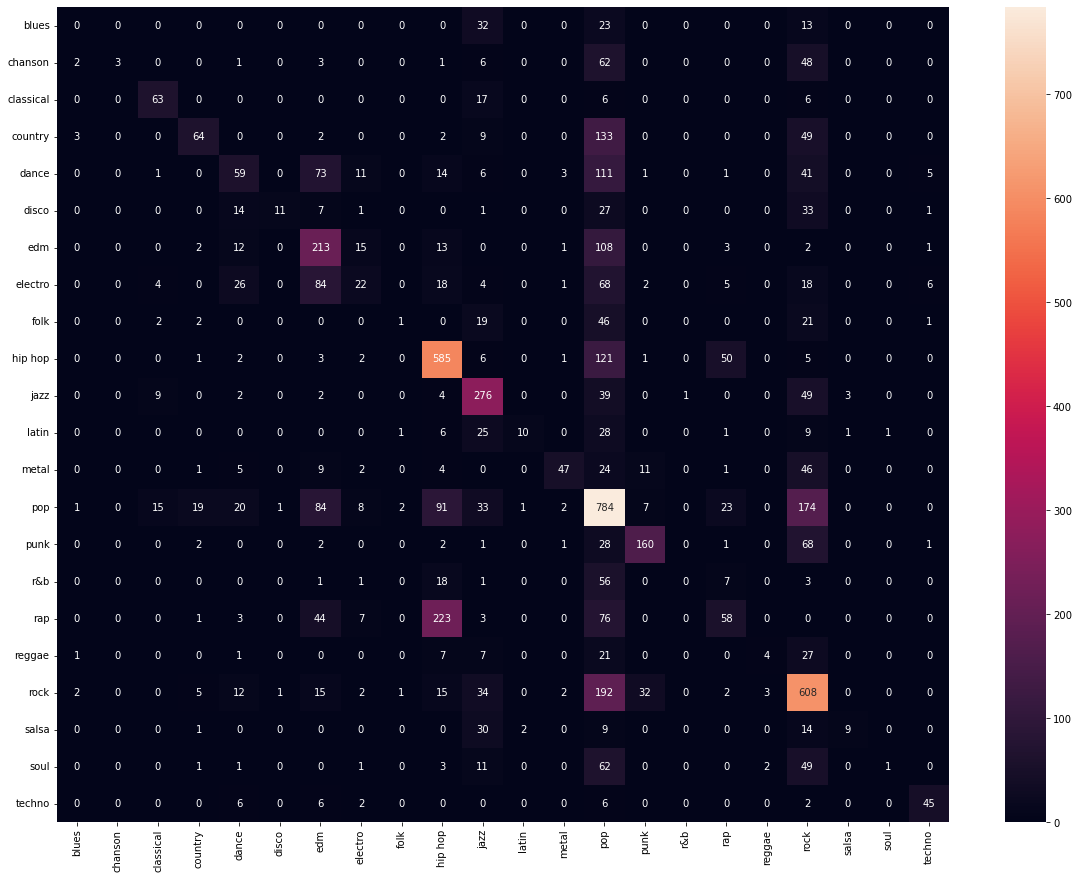

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred)

#The matrix is plotted as a heatmap
plt.figure(figsize=(20,15))

sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels=sorted(genres), yticklabels=sorted(genres));

The main problem that becomes apparent when looking at the confusion matrix is that many other genres are labelled as 'pop'.

<br>

This can be explained by the fact that pop is by definition a very broad genre and it is possible that our classifier has criteria encompassing a large part of the music for this particular genre.

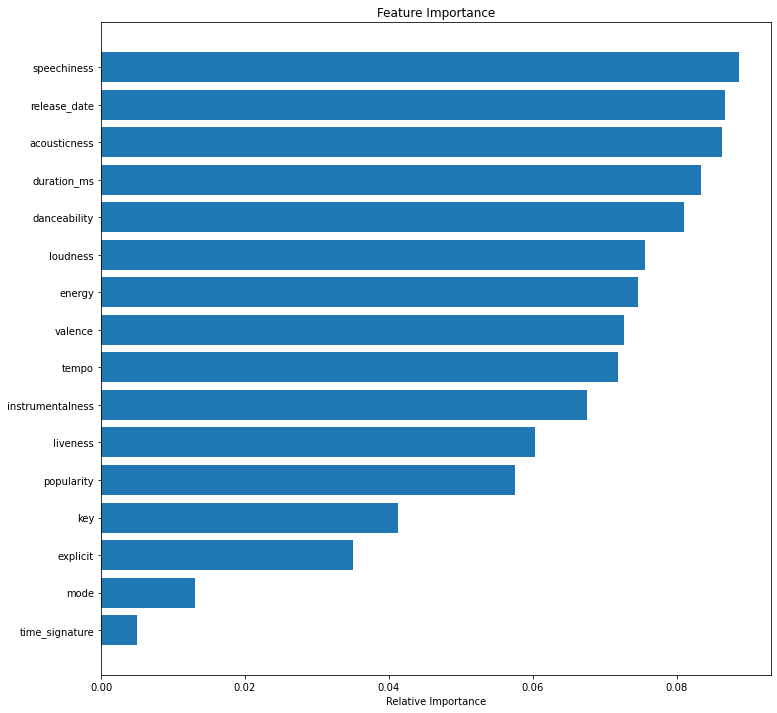

In [21]:
importances = clf6.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')

plt.barh(range(len(indices)), importances[indices], align='center');
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

This graph allows us to visualise which criteria are most important for the predictions made by our model.

As shown by the population graph of years of exit by gender, the date of exit is quite important for the predictions.

We also notice that the duration is a non-negligible criterion, which is surprising because at first sight the duration of a music does not allow us to guess its genre.

In [22]:
prediction = true_label.inverse_transform(clf3.predict(test))
prediction

array(['classical', 'classical', 'classical', ..., 'classical',
       'classical', 'classical'], dtype='<U9')

## Exercice 2 : Data analysis
---

In [23]:
data2=pd.read_csv("/kaggle/input/spotify/spotify_dataset_subset.csv")
data2

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Marry,Vorglühn Nachglühn,2018-10-12,"['discofox', 'partyschlager', 'schlager']",False,42,0.728,0.936,6,-2.557,1,0.1690,0.036800,0.000000,0.3230,0.509,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,ABBA,Chiquitita,1979,"['europop', 'swedish pop']",False,75,0.500,0.554,9,-8.108,1,0.0354,0.734000,0.000004,0.3120,0.372,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,Drug Squad,Dangerous Trouble,2010-08-09,['deep punk rock'],False,0,0.149,0.802,1,-9.954,1,0.0465,0.187000,0.785000,0.3560,0.478,185.689,5TeP9dfDZivCzM20ucyHsy,277053,4
3,Ahmad Jamal,Poinciana,1958-05-23,"['bebop', 'cool jazz', 'jazz', 'jazz piano']",False,0,0.604,0.622,9,-9.277,1,0.0282,0.495000,0.661000,0.8730,0.570,97.980,1nTaXD1Kt2qE8Oq92rjdrX,487201,4
4,Korn,Make Me Bad,1999-11-01,"['alternative metal', 'funk metal', 'nu metal'...",True,0,0.527,0.792,11,-6.693,0,0.0363,0.000122,0.037000,0.2490,0.424,110.038,0w6VKmDlUJyIqRcJ6hPwLf,235493,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,Yseult,Corps,2019-10-18,"['french indie pop', 'french pop']",False,68,0.501,0.211,5,-11.719,0,0.0386,0.937000,0.000574,0.1020,0.131,77.784,7qx03NsIL42jM03zFphnRO,313184,1
8694,Sheff G,Weight On Me,2020-05-15,"['brooklyn drill', 'new york drill', 'nyc rap']",True,75,0.801,0.533,3,-6.198,0,0.2220,0.707000,0.000043,0.1250,0.626,121.959,6A4hgJdwriera4WSUl4moW,157619,4
8695,Yugo Kanno,il vento d'oro,2018-12-19,"['anime score', 'japanese soundtrack']",False,70,0.491,0.915,11,-4.834,1,0.1430,0.006520,0.125000,0.0906,0.582,134.947,17VP4tofJ3evJbtY8Tk1Qi,295576,4
8696,Anlaya Project,Baltica,2018-05-14,[],False,10,0.637,0.646,1,-9.507,1,0.0703,0.002730,0.025800,0.0737,0.141,128.017,7xbyTxxzmgSthkBfCWuOcJ,512000,4


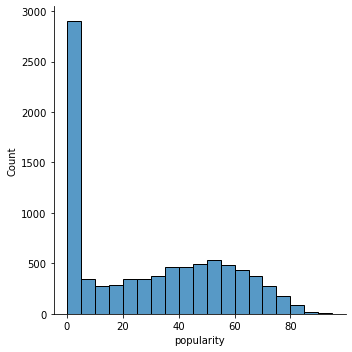

In [24]:
#The distribution of popularity is displayed
sns.displot(data2['popularity'])

We observe an overrepresentation of the value 0 in the popularity class: we suggest removing songs with 0 popularity to have a more balanced dataset

In [25]:
# Drop somes songs with 0 popularity
k=3000
for i in range(len(data2)):
  if data2['popularity'].loc[i]==0 and k>500:
    data2.drop([i],inplace=True)
    k=k-1
data2.reset_index(drop=True,inplace=True)

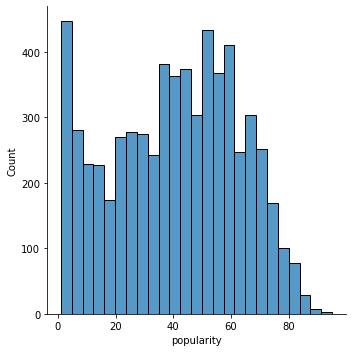

In [26]:
sns.displot(data2['popularity'])

The dataset is now balanced

Firstly, the artist's name is removed for the sake of simplification, although an artist is obviously responsible for the popularity of the sound 

In [27]:
#We only keep the year of the release
for i in range(len(data2)):
  data2['release_date'].loc[i]=int(data2['release_date'].loc[i][0:3])

#We clean up the data to keep only the important data for classification: 
#Deleting features that do not provide information on the style of music

data2_label=data2['popularity']
train_data2=data2.drop(['track_name','id','popularity','genres','artist_name','time_signature','mode'],axis=1)
features2 = train_data2.columns
train_data2

,release_date,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,201,False,0.728,0.936,6,-2.557,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,174631
1,197,False,0.500,0.554,9,-8.108,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,326320
2,198,False,0.664,0.613,0,-7.560,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,184587
3,201,True,0.429,0.964,8,-4.355,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,304072
4,197,False,0.471,0.770,0,-7.123,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,126907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,201,False,0.501,0.211,5,-11.719,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,313184
6239,202,True,0.801,0.533,3,-6.198,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,157619
6240,201,False,0.491,0.915,11,-4.834,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,295576
6241,201,False,0.637,0.646,1,-9.507,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,512000


In [28]:
scaler = MinMaxScaler()
train_data2 = scaler.fit_transform(train_data2)
train_data2

array([[0.9       , 0.        , 0.74666667, ..., 0.51991828, 0.68032306,
        0.0919856 ],
       [0.5       , 0.        , 0.51282051, ..., 0.37997957, 0.39527986,
        0.19593479],
       [0.6       , 0.        , 0.68102564, ..., 0.19713994, 0.45333596,
        0.09880823],
       ...,
       [0.9       , 0.        , 0.50358974, ..., 0.59448417, 0.63329532,
        0.17486659],
       [0.9       , 0.        , 0.65333333, ..., 0.14402451, 0.60077339,
        0.32317728],
       [0.9       , 0.        , 0.65128205, ..., 0.45250255, 0.7975334 ,
        0.13678156]])

### Predictions

In [29]:
X_train2,X_test2,y_train2,y_test2=model_selection.train_test_split(train_data2,data2_label)

X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape

((4682, 13), (1561, 13), (4682,), (1561,))

In this exercise we try to predict a popularity value of a sound, on a scale from 0 to 100
We first use a regression tree. We use the RMSE metrics to calculate the error of our model

#### Regression Tree

In [30]:
tree = DecisionTreeRegressor()
tree.fit(X_train2,y_train2)
y_pred2=tree.predict(X_test2)

print(mean_squared_error(y_test2,y_pred2,squared=False))

27.194061416001205


In [31]:
for i in range(10):
  print(f"True = {y_test2.to_numpy()[i]}, Predict = {y_pred2[i]}")

True = 37, Predict = 42.0
True = 26, Predict = 14.0
True = 54, Predict = 34.0
True = 37, Predict = 37.0
True = 78, Predict = 76.0
True = 29, Predict = 50.0
True = 36, Predict = 33.0
True = 29, Predict = 41.0
True = 82, Predict = 3.0
True = 42, Predict = 30.0


#### Linear Regression

In [32]:
reg=LinearRegression()
reg.fit(X_train2,y_train2)
y_pred2=reg.predict(X_test2)

print(mean_squared_error(y_test2,y_pred2,squared=False))

20.975563146020264


In [33]:
for i in range(10):
  print(f"True = {y_test2.to_numpy()[i]}, Predict = {y_pred2[i]}")

True = 37, Predict = 36.35302351241937
True = 26, Predict = 30.15633045399081
True = 54, Predict = 27.471028516890176
True = 37, Predict = 44.69418983289236
True = 78, Predict = 59.833325081121544
True = 29, Predict = 38.45260243930127
True = 36, Predict = 31.988730906504976
True = 29, Predict = 43.903506494861716
True = 82, Predict = 42.116455465851374
True = 42, Predict = 42.291004951129025


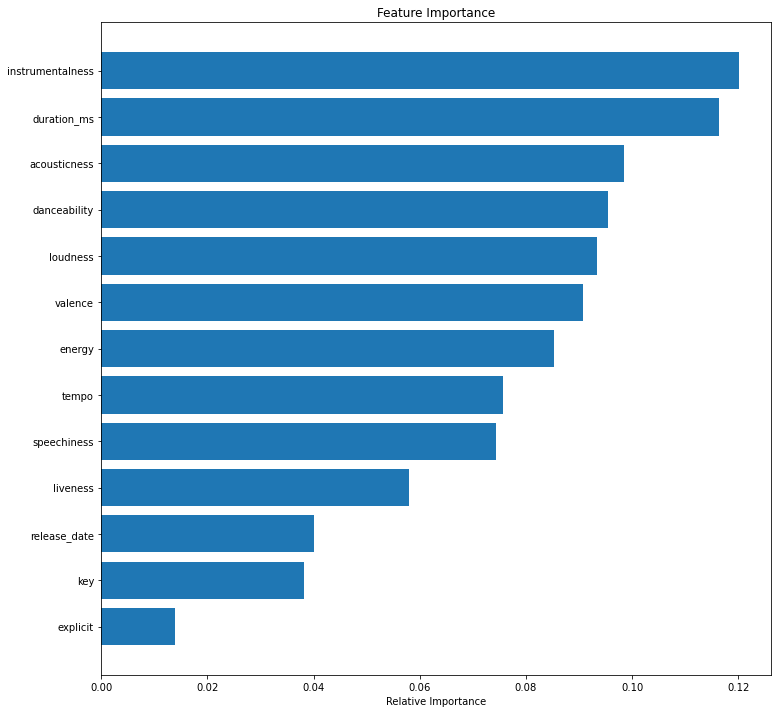

In [34]:
importances = tree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')

plt.barh(range(len(indices)), importances[indices], align='center');
plt.yticks(range(len(indices)), features2[indices])
plt.xlabel('Relative Importance');

### Improvements

#### 1 / The `artist_name` column is put back into the dataframe as an ID

In [35]:
#We transform the artists into a unique id for each artist
artist=data2['artist_name']
list=[]
k=0
for i in range(len(artist)):
  if artist.loc[i] not in list:
    k+=1
    list.append(artist.loc[i])
  artist.loc[i]=k
  
artist = pd.DataFrame({'artist': artist.values})
artist

,artist
0,1
1,2
2,3
3,4
4,5
...,...
6238,4112
6239,4113
6240,4114
6241,4115


In [36]:
#Artists are added to the dataframe
train_data2 = data2.drop(['track_name','id','popularity','genres','artist_name','time_signature','mode'],axis=1)
train_data2 = pd.concat([train_data2, artist], axis = 1)
feature3 = train_data2.columns
train_data2

,release_date,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,artist
0,201,False,0.728,0.936,6,-2.557,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,174631,1
1,197,False,0.500,0.554,9,-8.108,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,326320,2
2,198,False,0.664,0.613,0,-7.560,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,184587,3
3,201,True,0.429,0.964,8,-4.355,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,304072,4
4,197,False,0.471,0.770,0,-7.123,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,126907,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,201,False,0.501,0.211,5,-11.719,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,313184,4112
6239,202,True,0.801,0.533,3,-6.198,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,157619,4113
6240,201,False,0.491,0.915,11,-4.834,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,295576,4114
6241,201,False,0.637,0.646,1,-9.507,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,512000,4115


In [37]:
scaler = MinMaxScaler()
train_data2 = scaler.fit_transform(train_data2)
train_data2

array([[9.00000000e-01, 0.00000000e+00, 7.46666667e-01, ...,
        6.80323061e-01, 9.19856009e-02, 0.00000000e+00],
       [5.00000000e-01, 0.00000000e+00, 5.12820513e-01, ...,
        3.95279862e-01, 1.95934792e-01, 2.43013366e-04],
       [6.00000000e-01, 0.00000000e+00, 6.81025641e-01, ...,
        4.53335961e-01, 9.88082324e-02, 4.86026731e-04],
       ...,
       [9.00000000e-01, 0.00000000e+00, 5.03589744e-01, ...,
        6.33295321e-01, 1.74866593e-01, 9.99513973e-01],
       [9.00000000e-01, 0.00000000e+00, 6.53333333e-01, ...,
        6.00773393e-01, 3.23177279e-01, 9.99756987e-01],
       [9.00000000e-01, 0.00000000e+00, 6.51282051e-01, ...,
        7.97533402e-01, 1.36781563e-01, 1.00000000e+00]])

In [38]:
X_train2,X_test2,y_train2,y_test2=model_selection.train_test_split(train_data2,data2_label)

X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape

((4682, 14), (1561, 14), (4682,), (1561,))

In [39]:
tree2 = DecisionTreeRegressor()
tree2.fit(X_train2,y_train2)
y_pred2=tree2.predict(X_test2)

print(mean_squared_error(y_test2,y_pred2,squared=False))

27.811850694937842


In [40]:
reg=LinearRegression()
reg.fit(X_train2,y_train2)
y_pred2=reg.predict(X_test2)

print(mean_squared_error(y_test2,y_pred2,squared=False))

21.401813900427232


We observe identical performances: It's understandable because there are a lot of artists who appear only once so it's difficult to make a correlation between an artist and his popularity

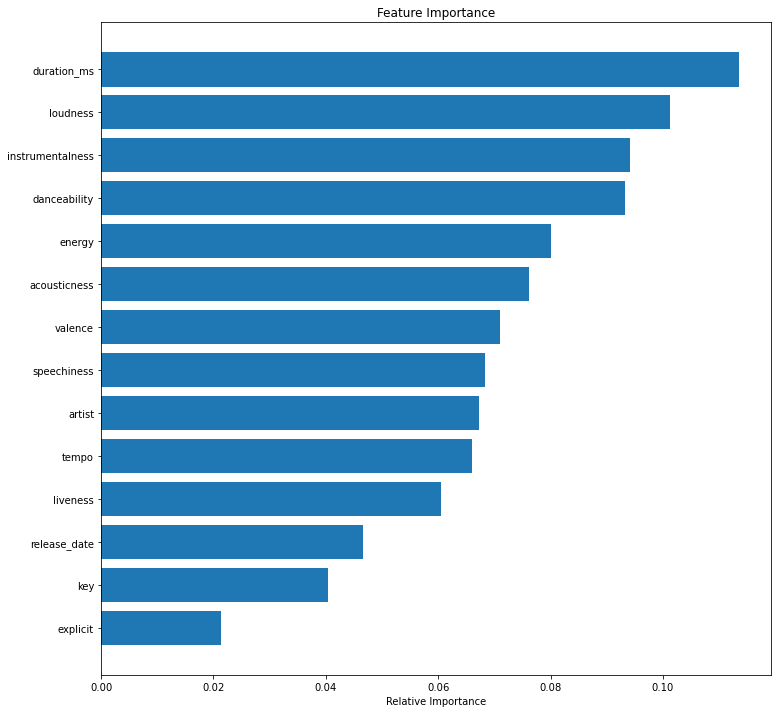

In [41]:
importances = tree2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')

plt.barh(range(len(indices)), importances[indices], align='center');
plt.yticks(range(len(indices)), feature3[indices])
plt.xlabel('Relative Importance');

It is clear that the feature *artist* is not very important after all

#### 2 / Division of popularity into 4 classes

As expected, the accuracy is low because it is difficult to predict popularity exactly on a scale of 0 to 100. It is more relevant to split popularity into 4 classes: ['not popular', 'somewhat popular', 'popular', 'very popular'] in order to get better results

In [42]:
data3=data2.copy()
for i in range(len(data3)):
  if data3['popularity'].loc[i]<25:
    data3['popularity'].loc[i]=1
  elif data3['popularity'].loc[i]<50:
    data3['popularity'].loc[i]=2
  elif data3['popularity'].loc[i]<75:
    data3['popularity'].loc[i]=3
  else:
    data3['popularity'].loc[i]=4

data3

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,1,Vorglühn Nachglühn,201,"['discofox', 'partyschlager', 'schlager']",False,2,0.728,0.936,6,-2.557,1,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,2,Chiquitita,197,"['europop', 'swedish pop']",False,4,0.500,0.554,9,-8.108,1,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,3,Never Tear Us Apart,198,"['australian rock', 'classic rock', 'dance roc...",False,3,0.664,0.613,0,-7.560,1,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,1GjbTNFImFrjFsNdleDe78,184587,3
3,4,Necromancy - Original Mix,201,[],True,1,0.429,0.964,8,-4.355,0,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,2gZ2IyTo7TNZKtMsMvFKCS,304072,4
4,5,Hate & War - Remastered,197,"['classic rock', 'permanent wave', 'punk', 'ro...",False,2,0.471,0.770,0,-7.123,1,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,1OtO2g2E1rnAW4KjNNeNui,126907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,4112,Corps,201,"['french indie pop', 'french pop']",False,3,0.501,0.211,5,-11.719,0,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,7qx03NsIL42jM03zFphnRO,313184,1
6239,4113,Weight On Me,202,"['brooklyn drill', 'new york drill', 'nyc rap']",True,4,0.801,0.533,3,-6.198,0,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,6A4hgJdwriera4WSUl4moW,157619,4
6240,4114,il vento d'oro,201,"['anime score', 'japanese soundtrack']",False,3,0.491,0.915,11,-4.834,1,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,17VP4tofJ3evJbtY8Tk1Qi,295576,4
6241,4115,Baltica,201,[],False,1,0.637,0.646,1,-9.507,1,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,7xbyTxxzmgSthkBfCWuOcJ,512000,4


In [43]:
data3_label=data3['popularity']
train_data3=data3.drop(['track_name','id','popularity','genres','artist_name'],axis=1)
train_data3

,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,201,False,0.728,0.936,6,-2.557,1,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,174631,4
1,197,False,0.500,0.554,9,-8.108,1,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,326320,4
2,198,False,0.664,0.613,0,-7.560,1,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,184587,3
3,201,True,0.429,0.964,8,-4.355,0,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,304072,4
4,197,False,0.471,0.770,0,-7.123,1,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,126907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,201,False,0.501,0.211,5,-11.719,0,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,313184,1
6239,202,True,0.801,0.533,3,-6.198,0,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,157619,4
6240,201,False,0.491,0.915,11,-4.834,1,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,295576,4
6241,201,False,0.637,0.646,1,-9.507,1,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,512000,4


In [44]:
scaler = MinMaxScaler()
train_data3 = scaler.fit_transform(train_data3)
train_data3

array([[0.9       , 0.        , 0.74666667, ..., 0.68032306, 0.0919856 ,
        0.8       ],
       [0.5       , 0.        , 0.51282051, ..., 0.39527986, 0.19593479,
        0.8       ],
       [0.6       , 0.        , 0.68102564, ..., 0.45333596, 0.09880823,
        0.6       ],
       ...,
       [0.9       , 0.        , 0.50358974, ..., 0.63329532, 0.17486659,
        0.8       ],
       [0.9       , 0.        , 0.65333333, ..., 0.60077339, 0.32317728,
        0.8       ],
       [0.9       , 0.        , 0.65128205, ..., 0.7975334 , 0.13678156,
        0.8       ]])

In [45]:
X_train3,X_test3,y_train3,y_test3=model_selection.train_test_split(train_data3,data3_label)

X_train3.shape,X_test3.shape,y_train3.shape,y_test3.shape

((4682, 15), (1561, 15), (4682,), (1561,))

We are no longer trying to predict a score out of 0-100 but a class (1,2,3 or 4) to quantify popularity. We will therefore use the metrics `f1_score` which is more adapted to the problem.

Logistic Regression

In [46]:
reg = LogisticRegression()
reg.fit(X_train3,y_train3)
y_pred3=reg.predict(X_test3)

print(f"F1-score = {f1_score(y_test3, y_pred3, average='micro')}")

F1-score = 0.4407431133888533


In [47]:
for i in range(10):
  print(f"True = {y_test3.to_numpy()[i]}, Predict = {y_pred3[i]}")

True = 3, Predict = 3
True = 1, Predict = 2
True = 1, Predict = 1
True = 2, Predict = 2
True = 3, Predict = 2
True = 2, Predict = 2
True = 3, Predict = 3
True = 3, Predict = 3
True = 3, Predict = 3
True = 2, Predict = 3


Random Forest

In [48]:
clf = RandomForestClassifier(n_estimators=2000)

clf.fit(X_train3, y_train3)
y_pred3 = clf.predict(X_test3)

print(f"F1-score = {f1_score(y_test3, y_pred3, average='micro')}")

F1-score = 0.484304932735426


In [49]:
for i in range(10):
  print(f"True = {y_test3.to_numpy()[i]}, Predict = {y_pred3[i]}")

True = 3, Predict = 1
True = 1, Predict = 1
True = 1, Predict = 1
True = 2, Predict = 1
True = 3, Predict = 3
True = 2, Predict = 2
True = 3, Predict = 2
True = 3, Predict = 2
True = 3, Predict = 3
True = 2, Predict = 3


Adequate but still imprecise accuracy scores are obtained

#### 3 / Management of the *'genres'* column

To use the genres column, we propose to calculate the average popularity for each genre. Then, depending on the genres displayed in the column, we replace the average popularity for the displayed genres. The difficulty lies in the format and the multidisciplinarity of the genres. In addition, some music simply does not have a genre. 

In [50]:
genres=data2['genres'].to_list()
for i in range(len(genres)):
  genres[i]=genres[i].replace('[', '')
  genres[i]=genres[i].replace(']', '')
  genres[i]=genres[i].replace("'", '')
  genres[i]=genres[i].replace(" ", '')
genres = pd.DataFrame(genres,columns=['genres'])
genres=genres.genres.str.split(",",expand=True,)
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,discofox,partyschlager,schlager,None,None,None,None,None,None,None,None,None,None,None,None,None
1,europop,swedishpop,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,australianrock,classicrock,dancerock,funkrock,mellowgold,newromantic,newwave,newwavepop,rock,softrock,None,None,None,None,None,None
3,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,classicrock,permanentwave,punk,rock,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,frenchindiepop,frenchpop,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6239,brooklyndrill,newyorkdrill,nycrap,None,None,None,None,None,None,None,None,None,None,None,None,None
6240,animescore,japanesesoundtrack,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6241,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [51]:
# The list of genres is extracted
def get_genre(labels):
    genre = []
    for i in range(len(labels)):
      for y in range(16):
        if str(labels.loc[i].values[y]) not in genre and str(labels.loc[i].values[y])!='None':
            genre.append(labels.loc[i].values[y])
    return genre

genre = get_genre(genres)
genre[:10]

['discofox',
 'partyschlager',
 'schlager',
 'europop',
 'swedishpop',
 'australianrock',
 'classicrock',
 'dancerock',
 'funkrock',
 'mellowgold']

In [52]:
#Popularity is recovered
data4=data2.copy()
popularity=data4['popularity']
popularity = pd.DataFrame({'popularity': popularity.values})
popularity

,popularity
0,42
1,75
2,71
3,2
4,37
...,...
6238,68
6239,75
6240,70
6241,10


In [53]:
#Assemble gender and popularity
genres = pd.concat([genres, popularity], axis = 1)
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,popularity
0,discofox,partyschlager,schlager,None,None,None,None,None,None,None,None,None,None,None,None,None,42
1,europop,swedishpop,None,None,None,None,None,None,None,None,None,None,None,None,None,None,75
2,australianrock,classicrock,dancerock,funkrock,mellowgold,newromantic,newwave,newwavepop,rock,softrock,None,None,None,None,None,None,71
3,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2
4,classicrock,permanentwave,punk,rock,None,None,None,None,None,None,None,None,None,None,None,None,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,frenchindiepop,frenchpop,None,None,None,None,None,None,None,None,None,None,None,None,None,None,68
6239,brooklyndrill,newyorkdrill,nycrap,None,None,None,None,None,None,None,None,None,None,None,None,None,75
6240,animescore,japanesesoundtrack,None,None,None,None,None,None,None,None,None,None,None,None,None,None,70
6241,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,10


We will not achieve this method

## Exercice 3 : Suggestions and similarity search
---



### A. Music recommendation

The objective of this exercise is to provide recommendations to users based on the music they listen to.

The approach chosen afterwards will be to return the 10 closest neighbours of a given piece of music in order to provide a list of recommendations.

In [54]:
# We import the dataset and view some entries
data_recommendations = pd.read_csv("/kaggle/input/spotify/recommendation_spotify.csv")

data_recommendations.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


The objective here is to use a similarity search approach, in order to propose a list of 10 suggestions based on the music listened to, we will search for the 10 closest neighbours of the music in question

Before doing so, it is necessary to prepare the data a little:

- The `id` here doesn't do us much good and doesn't indicate whether two pieces of music are similar, so we choose to remove it

- Similarly, the `name` is not a real indicator of the music itself and we will also remove this for our research

- The `exact exit date` will be abandoned in favour of the exit year, which will be used

- We choose to keep the `popularity` as well as the `year of release` as they may be representative of a certain style of music depending on the era or if the listener prefers to listen only to hits or not

- `Duration` will not be kept as it is not generally a criterion that people pay attention to when listening to music

- In the end, we decide not to keep the `artist`, which is a surprising choice because usually the first recommendations give us other music by this same artist.
<br>
We choose this approach so that users can discover other artists and also for a technical reason: it is complex to find an approach to use these for our K-NN search.
Indeed, simply changing each different artist into a numerical value and then normalising would imply that there are similarities between some artists whereas the distance (here Euclidean for our search) would simply depend on their alphabetical order (for a LabelEncoder use). In order to be able to correctly use the artists for this search, it would be necessary to first establish a similarity between artists according to their music.

<br>

As for the values we have chosen to keep, most of them are already between 0 and 1 but those that are not will be normalised

In [55]:
data_prepared = data_recommendations.copy()

# Drop useless columns
data_prepared.drop(columns=['artists', 'duration_ms', 'id', 'name', 'release_date'], inplace=True)

# Scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(data_prepared) 

data_scaled = pd.DataFrame(data_scaled, columns=data_prepared.columns,index=data_prepared.index)
data_scaled.head()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.994980,0.605263,0.224,0.0,0.000522,0.454545,0.3790,0.741868,0.0,0.12,0.096395,0.615900,0.6340,0.0
1,0.645582,0.862348,0.517,0.0,0.026400,0.454545,0.0809,0.825918,0.0,0.07,0.054995,0.356823,0.9500,0.0
2,0.996988,0.654858,0.186,0.0,0.000018,0.000000,0.5190,0.750168,1.0,0.04,0.179197,0.400810,0.6890,0.0
3,0.000174,0.738866,0.798,0.0,0.801000,0.181818,0.1280,0.825135,1.0,0.17,0.043769,0.525640,0.0422,0.0
4,0.296185,0.712551,0.707,1.0,0.000246,0.909091,0.4020,0.845102,0.0,0.02,0.079094,0.501324,0.2990,0.0


A KNN search is now used to return the 10 nearest neighbours:

In [56]:
data_numpy = data_scaled.to_numpy()

KNN = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(data_numpy)

In [57]:
#Show an example
index = 1433

data_recommendations.iloc[index]
distances, indices = KNN.kneighbors(data_numpy[index].reshape(1, -1))

display(data_recommendations.loc[[index], ['artists', 'name']])
recommendation = data_recommendations.loc[indices[0][1:], ['artists', 'name']]
recommendation

,artists,name
1433,"['Orchestre Piero Coppola', 'Piero Coppola']",Carmen : Acte II - Entracte


,artists,name
94476,['Al Bowlly'],"Goodnight, Angel"
60044,"['Samuel Barber', 'Isaac Stern', 'Leonard Bern...","Violin Concerto, Op. 14: II. Andante"
42037,"['Wolfgang Amadeus Mozart', 'Clara Haskil', 'A...",Sonate pour violon et piano No. 32 in B-Flat M...
41936,"['Wolfgang Amadeus Mozart', 'Szymon Goldberg',...","Sonate pour violon et piano No. 17 in C Major,..."
126901,"['Frédéric Chopin', 'Leopold Godowsky']","Nocturne No. 1 in E Minor, Op. 72"
41301,"['Robert Schumann', 'Karl Böhm', 'Staatskapell...","Schumann: Piano Concerto in A Minor, Op. 54: I..."
22250,"['Max Bruch', 'Jascha Heifetz', 'The New Symph...",II. Adagio from Violin Concerto No. 1 in G Min...
41612,"['Felix Mendelssohn', 'Arturo Toscanini']","A Midsummer Night's Dream, Op. 21: Nocturne"
41984,"['Wolfgang Amadeus Mozart', 'Juilliard String ...","Quatuor à cordes No. 19 in C Major, K. 465 ""Le..."
158965,"['Igor Stravinsky', 'Walter Straram Concerts O...",The Firebird: VII Interlude (berceuse)


### B. User feedback

It is possible to extend this method to take into account user feedback.

The concept is that each row is a user and there are as many columns as there are songs in the Spotify database and users can indicate whether they like (1) or dislike (0) a song.

The diagram below gives an overview of the data:
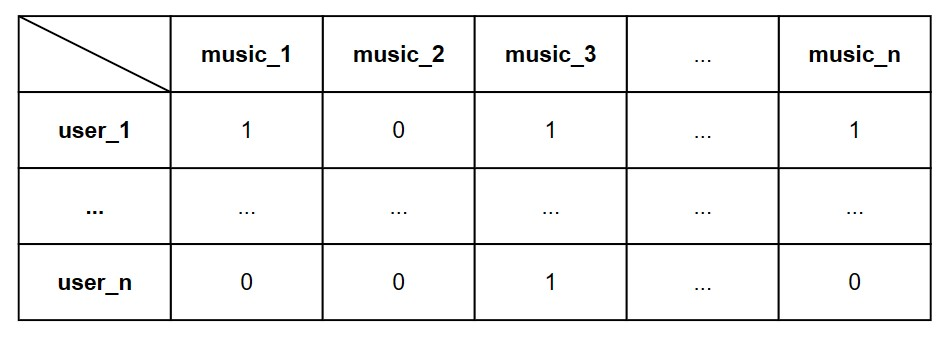

This feedback from users could then be used to find similarities between users.
In this case, if a user has very similar tastes to another, it would be wise to suggest music that the other user has enjoyed.